In [1]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import engine

from typing import Optional, Dict, Any, List
from ciso8601 import parse_datetime
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import time
import plotly.graph_objects as go
from ta import add_all_ta_features
from ta.utils import dropna
from datetime import datetime
plt.rcParams["figure.figsize"] = (100,10)


In [2]:
# btc = FtxClient()
# btc_df = btc.get_all_markets('BTC-PERP')


In [3]:
# db=pd.json_normalize(btc_df)

# db.to_csv('data/btc1m.csv')

In [4]:
df = pd.read_csv('btc1m.csv')

In [5]:
df.tail(10)



,Unnamed: 0,startTime,time,open,high,low,close,volume
1160258,1160258,2019-07-20T22:03:00+00:00,1.563660e+12,10977.25,10979.00,10977.25,10978.00,0.000000e+00
1160259,1160259,2019-07-20T22:04:00+00:00,1.563660e+12,10978.00,10979.25,10977.25,10979.25,0.000000e+00
1160260,1160260,2019-07-20T22:05:00+00:00,1.563660e+12,10977.25,10979.25,10964.50,10977.75,1.485180e+06
1160261,1160261,2019-07-20T22:06:00+00:00,1.563660e+12,10977.75,10977.75,10965.75,10965.75,0.000000e+00
1160262,1160262,2019-07-20T22:07:00+00:00,1.563660e+12,10965.75,10977.25,10959.25,10974.25,1.483335e+06
1160263,1160263,2019-07-20T22:08:00+00:00,1.563660e+12,10974.25,10976.25,10971.00,10971.00,8.622317e+05
1160264,1160264,2019-07-20T22:09:00+00:00,1.563661e+12,10971.00,10972.00,10962.75,10967.25,8.616816e+05
1160265,1160265,2019-07-20T22:10:00+00:00,1.563661e+12,10969.25,10969.25,10964.00,10964.75,0.000000e+00
1160266,1160266,2019-07-20T22:11:00+00:00,1.563661e+12,10964.75,10964.75,10962.25,10963.00,0.000000e+00
1160267,1160267,2019-07-20T12:35:00+00:00,1.563626e+12,10564.25,10572.25,10560.50,10567.75,6.365293e+05


## mean rev algo

In [6]:
ma = 30
# calc rate ofreturn close to close
df['returns'] = np.log(df["close"]).diff()
# add column to keep track of mean or moving average
df['ma'] = df['close'].rolling(ma).mean()
# to decide when too far away from mean add column called ratio
df['ratio'] = df['close'] / df['ma']
# create variable for price points that might work
percentiles = [5, 10, 50, 90, 95]
# get a look at where percentiles are w numpy percential function on btc ratio column
np.percentile(df['ratio'].dropna(), percentiles)
p = np.percentile(df['ratio'].dropna(), percentiles)

In [7]:
# Define place where we short at 95th percentile and long at 5th
short = p[-1]
long = p[0]
# use np.where which is numpys version of excels 'if' function
# add column to df for position value
# look at ratio column -1 indicates short otherwise nan
df['position'] = np.where(df.ratio > short, -1, np.nan)
# when long position at 1 instead of np.nan we leave btc['position'] where it is.
df['position'] = np.where(df.ratio < long, 1, df['position'])
# This strat isnt neutral, its always in a long or short.
df['position'] = df['position'].ffill()
df['strat_return'] = df['returns'] * df['position'].shift()

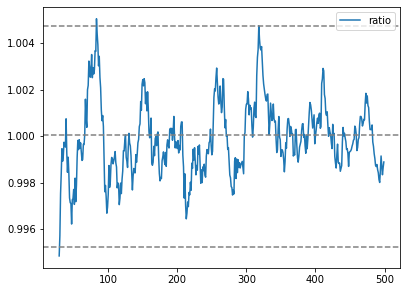

In [8]:
# visual look at ratio column
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

df['ratio'].head(500).dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--');
# can see ratio move around mean

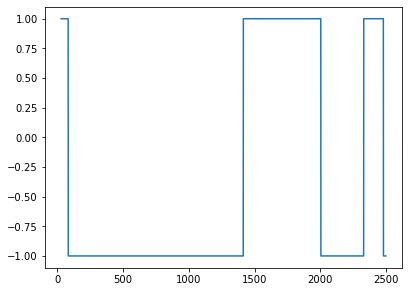

In [9]:
# df.position.dropna().plot()
plt.plot(df.head(2500).position.dropna())
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


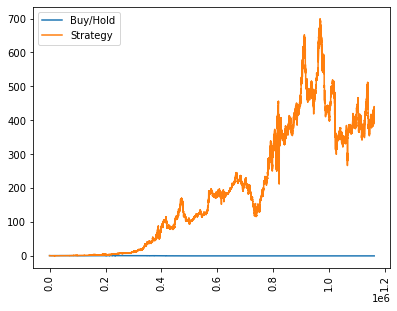

In [10]:
plt.plot(np.exp(df['returns'].dropna()).cumprod(), label='Buy/Hold')
plt.plot(np.exp(df['strat_return'].dropna()).cumprod(), label='Strategy')
plt.xticks(rotation=90)
plt.legend();

In [11]:
df['min_ret'] = df['close']/df['close'].shift(1)-1
df['pct_min_ret'] = df['close'].pct_change(1)
df['min_ret_log'] = np.log(df['close']/df['close'].shift(1))
df['cumret'] = np.cumsum(df['min_ret'])
df['strat_cumret'] = df['min_ret'] * df['position'].shift()
print("Market cumulative returns: ", df['cumret'].iloc[-1])
print("Strategy Cumulative Returns: ", df['strat_cumret'].iloc[-1])

Market cumulative returns:  0.5769549825119703
Strategy Cumulative Returns:  0.03605308765848769


In [12]:
df['min_retmark'] = df['close'].pct_change()
cum_retmark = (df.min_retmark + 1).cumprod()*1000
#df['strat_ret'] = df['min_retmark'] * df['position'].shift(1)-1
cum_retmark.iloc[-1]

219.62611966659242

In [13]:
df = df.drop(df.columns[0], axis = 1) 

In [14]:
df = df.drop("startTime", axis=1)

In [15]:
df['goodTrades'] = np.where((df.strat_return / df.close) * .15 > df.returns / df.close, 1, np.nan)
df['goodTrades'] = np.where((df.strat_return / df.close)* .15 < df.returns / df.close, 0, df['goodTrades'])
df = df.drop("time", axis=1)
df

,open,high,low,close,volume,returns,ma,ratio,position,strat_return,min_ret,pct_min_ret,min_ret_log,cumret,strat_cumret,min_retmark,goodTrades
0,48150.00,48167.00,48103.00,48117.00,7.867722e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48117.00,48128.00,48114.00,48118.00,4.996471e+05,0.000021,NaN,NaN,NaN,NaN,0.000021,0.000021,0.000021,0.000021,NaN,0.000021,NaN
2,48118.00,48120.00,48107.00,48107.00,5.811371e+05,-0.000229,NaN,NaN,NaN,NaN,-0.000229,-0.000229,-0.000229,-0.000208,NaN,-0.000229,NaN
3,48103.00,48121.00,48080.00,48121.00,1.460518e+06,0.000291,NaN,NaN,NaN,NaN,0.000291,0.000291,0.000291,0.000083,NaN,0.000291,NaN
4,48121.00,48156.00,48121.00,48142.00,7.713480e+05,0.000436,NaN,NaN,NaN,NaN,0.000436,0.000436,0.000436,0.000520,NaN,0.000436,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160263,10974.25,10976.25,10971.00,10971.00,8.622317e+05,-0.000296,10960.016667,1.001002,-1.0,0.000296,-0.000296,-0.000296,-0.000296,0.613737,0.000296,-0.000296,1.0
1160264,10971.00,10972.00,10962.75,10967.25,8.616816e+05,-0.000342,10960.866667,1.000582,-1.0,0.000342,-0.000342,-0.000342,-0.000342,0.613396,0.000342,-0.000342,1.0
1160265,10969.25,10969.25,10964.00,10964.75,0.000000e+00,-0.000228,10961.683333,1.000280,-1.0,0.000228,-0.000228,-0.000228,-0.000228,0.613168,0.000228,-0.000228,1.0
1160266,10964.75,10964.75,10962.25,10963.00,0.000000e+00,-0.000160,10962.375000,1.000057,-1.0,0.000160,-0.000160,-0.000160,-0.000160,0.613008,0.000160,-0.000160,1.0


In [16]:
print(df['goodTrades'].value_counts())

1.0    542878
0.0    539396
Name: goodTrades, dtype: int64


In [17]:
df = add_all_ta_features(
    df, open="open", high="high", low="low", close="close", volume="volume")
df

C:\Users\tbrid\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\tbrid\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,volume,returns,ma,ratio,position,strat_return,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,48150.00,48167.00,48103.00,48117.00,7.867722e+05,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.946131,NaN,0.000000
1,48117.00,48128.00,48114.00,48118.00,4.996471e+05,0.000021,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002078,0.002078,0.002078
2,48118.00,48120.00,48107.00,48107.00,5.811371e+05,-0.000229,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.022860,-0.022863,-0.020783
3,48103.00,48121.00,48080.00,48121.00,1.460518e+06,0.000291,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029102,0.029098,0.008313
4,48121.00,48156.00,48121.00,48142.00,7.713480e+05,0.000436,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043640,0.043630,0.051957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160263,10974.25,10976.25,10971.00,10971.00,8.622317e+05,-0.000296,10960.016667,1.001002,-1.0,0.000296,...,-49.650350,16.584559,NaN,0.132342,83.436863,22.971321,60.465542,-0.029615,-0.029619,-77.199327
1160264,10971.00,10972.00,10962.75,10967.25,8.616816e+05,-0.000342,10960.866667,1.000582,-1.0,0.000342,...,-60.139860,13.479412,NaN,0.098115,76.209352,33.618927,42.590425,-0.034181,-0.034187,-77.207120
1160265,10969.25,10969.25,10964.00,10964.75,0.000000e+00,-0.000228,10961.683333,1.000280,-1.0,0.000228,...,-67.132867,11.491912,NaN,0.057033,61.028239,39.100790,21.927449,-0.022795,-0.022798,-77.212316
1160266,10964.75,10964.75,10962.25,10963.00,0.000000e+00,-0.000160,10962.375000,1.000057,-1.0,0.000160,...,-72.027972,9.066176,NaN,-0.029636,47.155037,40.711639,6.443398,-0.015960,-0.015962,-77.215953


In [18]:
df[:] = np.nan_to_num(df)

In [19]:
target = df["goodTrades"]
target_names = [0, 1]

In [20]:
data = df.drop(["goodTrades", "strat_return", "position"], axis=1)
feature_names = data.columns
data.dropna()

,open,high,low,close,volume,returns,ma,ratio,min_ret,pct_min_ret,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,48150.00,48167.00,48103.00,48117.00,7.867722e+05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,117.946131,0.000000,0.000000
1,48117.00,48128.00,48114.00,48118.00,4.996471e+05,0.000021,0.000000,0.000000,0.000021,0.000021,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.002078,0.002078,0.002078
2,48118.00,48120.00,48107.00,48107.00,5.811371e+05,-0.000229,0.000000,0.000000,-0.000229,-0.000229,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.022860,-0.022863,-0.020783
3,48103.00,48121.00,48080.00,48121.00,1.460518e+06,0.000291,0.000000,0.000000,0.000291,0.000291,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029102,0.029098,0.008313
4,48121.00,48156.00,48121.00,48142.00,7.713480e+05,0.000436,0.000000,0.000000,0.000436,0.000436,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.043640,0.043630,0.051957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160263,10974.25,10976.25,10971.00,10971.00,8.622317e+05,-0.000296,10960.016667,1.001002,-0.000296,-0.000296,...,-49.650350,16.584559,0.0,0.132342,83.436863,22.971321,60.465542,-0.029615,-0.029619,-77.199327
1160264,10971.00,10972.00,10962.75,10967.25,8.616816e+05,-0.000342,10960.866667,1.000582,-0.000342,-0.000342,...,-60.139860,13.479412,0.0,0.098115,76.209352,33.618927,42.590425,-0.034181,-0.034187,-77.207120
1160265,10969.25,10969.25,10964.00,10964.75,0.000000e+00,-0.000228,10961.683333,1.000280,-0.000228,-0.000228,...,-67.132867,11.491912,0.0,0.057033,61.028239,39.100790,21.927449,-0.022795,-0.022798,-77.212316
1160266,10964.75,10964.75,10962.25,10963.00,0.000000e+00,-0.000160,10962.375000,1.000057,-0.000160,-0.000160,...,-72.027972,9.066176,0.0,-0.029636,47.155037,40.711639,6.443398,-0.015960,-0.015962,-77.215953


In [21]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = .4, random_state=42)

In [22]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

C:\Users\tbrid\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

In [ ]:
trend = dropna(trend)

In [ ]:
for col in trend.columns:
    print(col)

In [ ]:
trend['goodTrades'] = np.where(trend.strat_return > trend.returnsT, 1, np.nan)
trend['goodTrades'] = np.where(trend.strat_return < trend.returnsT, 0, trend['goodTrades'])
trend[:] = np.nan_to_num(trend)
trend

In [ ]:
target = trend["goodTrades"]
target_names = [0, 1]

In [ ]:
data = trend.drop(["goodTrades", "returnsT", "time", "returns", "position", "strat_return", "entry", "signal", "ratio", "strat"],  axis=1)
feature_names = data.columns
data.dropna()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

In [ ]:
from sklearn import tree
import graphviz

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=data.columns,  
                      class_names=['0', '1'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("btc1m") 
graph 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
for max_depth in range (2,40):
    rf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, max_leaf_nodes=100)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

In [ ]:
sorted(zip(rf.feature_importances_, feature_names), reverse=True)